# Imports

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import hyperspy.api as hs
from esmpy.estimators import SmoothNMF
import esmpy.datasets as ds

import matplotlib.pyplot as plt
import numpy as np

from esmpy.models.EDXS_function import print_concentrations_from_W

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating artificial datasets and loading them

If the datasets were already generated, they are not generated again

**This is optional**

In [5]:
ds.generate_built_in_datasets(seeds_range=5)
spim = ds.load_particules(sample = 0)

# Loading your data and settings

There are three things to fill here : 
- An input filename in the ``hs.load()`` function
- The acquisition parameters in the ``spim.set_analysis_parameters()`` function. Be careful the previous metadata are overwritten. (I still need to build a function that does not overwrite the already present settings)
- if required you can set the concentrations of some elements in some phases with the function ``spim.set_fixed_W()``. The name of the phases can be changed.

In [6]:
spim = hs.load("../generated_datasets/FpBrgCaPv_N293_paper/sample_5.hspy")

# spim.axes_manager[-1].offset = 12000
spim.set_signal_type("EDS_ESMPY")
spim.set_analysis_parameters(beam_energy = 200,
azimuth_angle = 0.0,
elevation_angle = 22.0,
tilt_stage = 0.0,
elements = ["Si","Mg","Fe"],
thickness = 200e-7,
density = 3.5,
detector_type = "SDD_efficiency.txt",
width_slope = 0.01,
width_intercept = 0.065,
xray_db = "default_xrays.json")
G = spim.build_G("bremsstrahlung", norm = True)
fW = spim.set_fixed_W({"p0" : {"Si" : 0.0},"p1" : {"Fe" : 0.0}, "p2" : {"Mg" : 0.0}})

# Problem solving

Full hyperspy syntax

## Loading analysis parameters

In [7]:
G = spim.build_G("bremsstrahlung", norm = True)
shape_2d = spim.shape_2d
phases = spim.phases
maps = spim.maps
print(maps[0,20:200])
print(G)
est = SmoothNMF( n_components = 3,tol=0.000001, max_iter = 1000, G = None, mu=0, lambda_L=0,  force_simplex=False) #  true_D = phases, true_A = weights

[1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 0.9925 0.99   0.9925 1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 0.985  0.9625 0.945  0.9325 0.925  0.9225 0.925  0.9325 0.945  0.9625
 0.985  1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     0.9825 0.95   0.9225 0.9    0.8825 0.87   0.8625 0.86
 0.8625 0.87   0.8825 0.9    0.9225 0.95   0.9825 1.    

## Calculating the decomposition

/!\ Depending on the parameters you choose and the size of the data it might take a while

In [196]:
out = spim.decomposition(algorithm = est, return_info=True)

TypeError: To perform a decomposition the data must be of the float or complex type, but the current type is 'int64'. To fix this issue, you can change the type using the change_dtype method (e.g. s.change_dtype('float64')) and then repeat the decomposition.
No decomposition was performed.

## Getting the losses and the results of the decomposition

- First cell : Printing the resulting concentrations.
- Second cell : Ploting the resulting spectra
- Thrid cell : Ploting the resulting abundances

In [ ]:
print_concentrations_from_W(est.W_, elements = spim.metadata.Sample.elements)

AttributeError: 'SmoothNMF' object has no attribute 'W_'

In [ ]:
spim.plot_decomposition_loadings(3)

RuntimeError: No learning results found. A 'decomposition' needs to be performed first.

In [ ]:
spim.plot_decomposition_factors(3)

RuntimeError: No learning results found. A 'decomposition' needs to be performed first.

# Problem Solving

With the usual scikit use

In [19]:
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse, ordered_r2, ordered_mae
from matplotlib.widgets import Slider

def plot_results(Ddot, D, Hdotflat, Hflat, n_pixel_side):
    fontsize = 30
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = Hflat.shape[0]
    L = D.shape[0]

    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    mse = ordered_mse(Hdotflat, Hflat, true_inds)
    mae = ordered_mae(Hdotflat, Hflat, true_inds)
    r2 = ordered_r2(Hdotflat, Hflat, true_inds)


    fig, axes = plt.subplots(K,3,figsize = (scale/K * 3 * aspect_ratio,scale))
    plt.subplots_adjust(bottom=0.25)
    ax_slide = plt.axes([0.25, 0.1, 0.65, 0.03])
    s_factor = Slider(ax_slide, 'Smoothing factor',
                  0.1, 6, valinit=6, valstep=0.2)
    x = np.linspace(0,1, num = L)
    for i in range(K): 
        axes[2,i].plot(x,Ddot.T[i,:],'bo',label='truth',linewidth=4)
        axes[2,i].plot(x,D[:,true_inds[i]],'r-',label='reconstructed',markersize=3.5)
        axes[2,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
        axes[2,i].set_xlim(0,1)

        axes[1,i].imshow((Hflat[true_inds[i],:]).reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax , cmap=cmap)
        axes[1,i].set_title("R2: {:.2f}".format(r2[true_inds[i]]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        axes[1,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        im = axes[0,i].imshow(Hdotflat[i].reshape(n_pixel_side,n_pixel_side),vmin = vmin, vmax = vmax, cmap=cmap)
        axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
        axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
        axes[2,0].legend()
    rows = ["True maps","Reconstructed maps","Spectra"]

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=fontsize)


    fig.subplots_adjust(right=0.84)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
    fig.colorbar(im,cax=cbar_ax)

    # fig.tight_layout()

    plt.show()

def downsample(X,n):
    b = X.shape[2]//n
    return X.reshape(X.shape[0], -1, n, b, n).sum((-1, -3)) /(n*n)

def downsample_flat(X,n, pixels_side):
    X = X.reshape((-1, pixels_side,pixels_side))
    X = downsample(X,n)
    return X.reshape((-1, pixels_side*pixels_side//n//n))



In [20]:
pixels_side = 64



In [25]:
G = spim.build_G("bremsstrahlung")
shape_2d = spim.shape_2d
# phases, weights = spim.phases, spim.weights
X = spim.X
est = SmoothNMF( n_components = 3,tol=0.000001, max_iter = 1000, G = None, lambda_L= 0., mu=0., force_simplex=False, init="nndsvdar")
Ximg = X.reshape((-1, pixels_side,pixels_side))
print(Ximg.shape)

downsampling_factors = [16,8,4,2,1]
results_0 = []
results_1 = []
results_2 = []
results_max = []

Hflat =None
W = None
for i in range(len(downsampling_factors)):
    downsample_factor_results_0 = []
    downsample_factor_results_1 = []
    downsample_factor_results_2 = []


    n = downsampling_factors[i]
    X_ = downsample(Ximg,n)
    Xflat = X_.reshape((X_.shape[0], -1))
    if (i > 0):
        print(Hflat.shape)
        factor = downsampling_factors[i-1]//downsampling_factors[i]
        H = Hflat.reshape((-1, pixels_side//n//factor, pixels_side//n//factor))
        H = H.repeat(factor, axis = 1).repeat(factor, axis = 2)
        Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.1
        print(H.shape)
        print(Xflat.shape, W.shape, Hflat.shape)
        W =  W 
    
    # est = SmoothNMF( n_components = 3,tol=0.000001, max_iter = 1000, G = None, lambda_L= 0., mu=0., force_simplex=False, init="nndsvdar", fixed_W=W, random_state=False)
    D = est.fit_transform(Xflat, W=W, H=Hflat, n_pixel_side=pixels_side//n)
    Hflat = est.H_
    W = est.W_

    Wdot = spim.phases
    Hflatdot = downsample_flat(spim.maps,n, pixels_side)

    angles, _ = find_min_angle(Wdot.T, W.T, unique=True, get_ind=True)

     
    results_0.append(angles[0])
    results_1.append(angles[1])
    results_2.append(angles[2])
    results_max.append(max(angles))

   


    plot_results(Wdot, W, Hflatdot, Hflat, pixels_side//n)

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_0)
plt.show()

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_1)

plt.show()

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_2)
plt.show()

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_max)
plt.show()

(500, 64, 64)
3
It 10 / 1000: loss 0.002,  422.685 it/s
It 20 / 1000: loss 0.002,  542.559 it/s
It 30 / 1000: loss 0.002,  564.938 it/s
It 40 / 1000: loss 0.002,  571.246 it/s
It 50 / 1000: loss 0.002,  568.044 it/s
It 60 / 1000: loss 0.002,  562.387 it/s
It 70 / 1000: loss 0.002,  570.841 it/s
It 80 / 1000: loss 0.002,  579.784 it/s
It 90 / 1000: loss 0.002,  573.230 it/s
It 100 / 1000: loss 0.002,  577.063 it/s
It 110 / 1000: loss 0.002,  577.955 it/s
It 120 / 1000: loss 0.002,  570.057 it/s
It 130 / 1000: loss 0.002,  566.396 it/s
It 140 / 1000: loss 0.002,  561.664 it/s
It 150 / 1000: loss 0.002,  563.623 it/s
It 160 / 1000: loss 0.002,  569.539 it/s
It 170 / 1000: loss 0.002,  575.937 it/s
It 180 / 1000: loss 0.002,  584.256 it/s
It 190 / 1000: loss 0.002,  593.238 it/s
It 200 / 1000: loss 0.002,  599.601 it/s
It 210 / 1000: loss 0.002,  598.067 it/s
It 220 / 1000: loss 0.002,  600.787 it/s
It 230 / 1000: loss 0.002,  603.440 it/s
It 240 / 1000: loss 0.002,  610.911 it/s
It 250 / 

(500, 64, 64)
3
It 10 / 1000: loss 0.008,  283.087 it/s
It 20 / 1000: loss 0.008,  345.664 it/s
It 30 / 1000: loss 0.008,  332.809 it/s
It 40 / 1000: loss 0.008,  322.156 it/s
It 50 / 1000: loss 0.008,  339.762 it/s
It 60 / 1000: loss 0.008,  337.083 it/s
It 70 / 1000: loss 0.008,  340.611 it/s
It 80 / 1000: loss 0.008,  342.614 it/s
It 90 / 1000: loss 0.008,  341.760 it/s
It 100 / 1000: loss 0.008,  347.846 it/s
It 110 / 1000: loss 0.008,  355.107 it/s
It 120 / 1000: loss 0.008,  360.083 it/s
It 130 / 1000: loss 0.008,  361.852 it/s
It 140 / 1000: loss 0.008,  365.540 it/s
It 150 / 1000: loss 0.008,  364.815 it/s
It 160 / 1000: loss 0.008,  361.563 it/s
It 170 / 1000: loss 0.008,  364.634 it/s
It 180 / 1000: loss 0.008,  367.943 it/s
It 190 / 1000: loss 0.008,  371.950 it/s
It 200 / 1000: loss 0.008,  372.860 it/s
It 210 / 1000: loss 0.008,  366.042 it/s
It 220 / 1000: loss 0.008,  367.422 it/s
It 230 / 1000: loss 0.008,  366.806 it/s
It 240 / 1000: loss 0.008,  365.036 it/s
It 250 / 

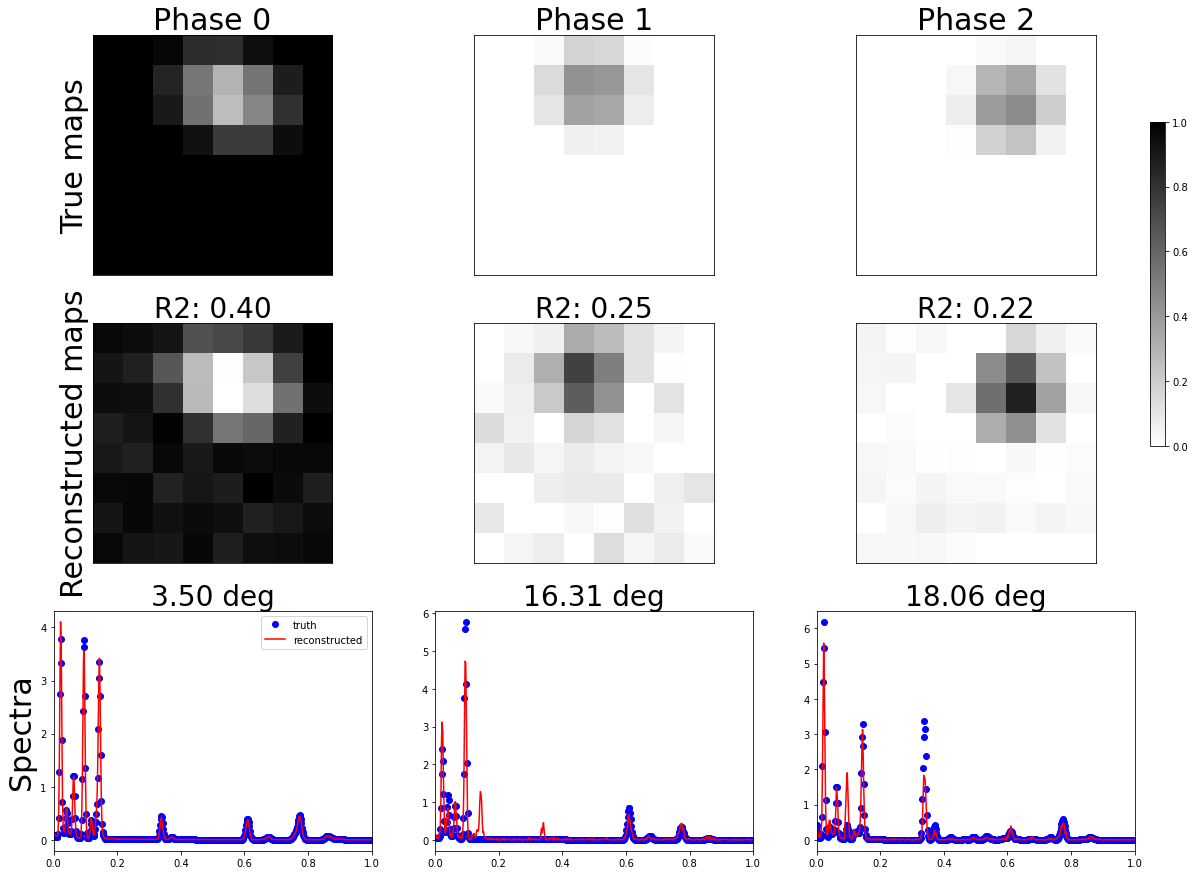

(3, 64)
(3, 16, 16)
(500, 256) (500, 3) (3, 256)
3
It 10 / 1000: loss 0.023,  117.814 it/s
It 20 / 1000: loss 0.023,  129.637 it/s
It 30 / 1000: loss 0.023,  138.721 it/s
It 40 / 1000: loss 0.023,  142.852 it/s
It 50 / 1000: loss 0.023,  147.051 it/s
It 60 / 1000: loss 0.023,  149.598 it/s
It 70 / 1000: loss 0.023,  153.306 it/s
It 80 / 1000: loss 0.023,  154.342 it/s
It 90 / 1000: loss 0.023,  155.804 it/s
It 100 / 1000: loss 0.023,  157.739 it/s
It 110 / 1000: loss 0.023,  156.739 it/s
It 120 / 1000: loss 0.023,  157.924 it/s
It 130 / 1000: loss 0.023,  158.295 it/s
It 140 / 1000: loss 0.023,  158.043 it/s
It 150 / 1000: loss 0.023,  157.789 it/s
It 160 / 1000: loss 0.023,  158.142 it/s
It 170 / 1000: loss 0.023,  158.348 it/s
It 180 / 1000: loss 0.023,  159.047 it/s
It 190 / 1000: loss 0.023,  158.941 it/s
It 200 / 1000: loss 0.023,  159.577 it/s
It 210 / 1000: loss 0.023,  160.319 it/s
It 220 / 1000: loss 0.023,  160.321 it/s
It 230 / 1000: loss 0.023,  160.958 it/s
It 240 / 1000: 

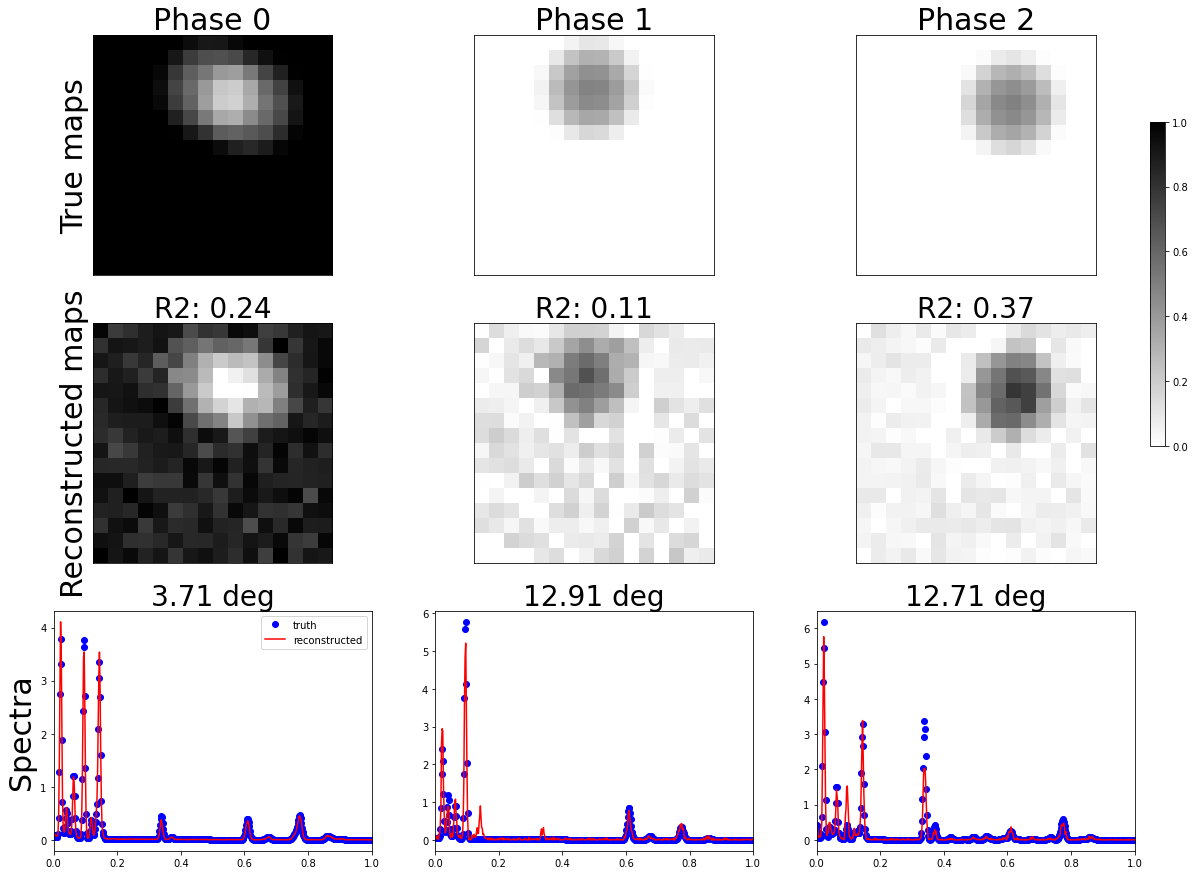

(3, 256)
(3, 32, 32)
(500, 1024) (500, 3) (3, 1024)
3
It 10 / 1000: loss 0.057,  46.982 it/s
It 20 / 1000: loss 0.057,  52.346 it/s
It 30 / 1000: loss 0.057,  54.913 it/s
It 40 / 1000: loss 0.057,  56.153 it/s
It 50 / 1000: loss 0.057,  56.784 it/s
It 60 / 1000: loss 0.057,  57.271 it/s
It 70 / 1000: loss 0.057,  57.800 it/s
It 80 / 1000: loss 0.057,  58.135 it/s
It 90 / 1000: loss 0.057,  58.359 it/s
It 100 / 1000: loss 0.057,  58.384 it/s
It 110 / 1000: loss 0.057,  58.035 it/s
It 120 / 1000: loss 0.057,  58.196 it/s
It 130 / 1000: loss 0.057,  58.373 it/s
It 140 / 1000: loss 0.057,  58.135 it/s
It 150 / 1000: loss 0.057,  57.872 it/s
It 160 / 1000: loss 0.057,  57.903 it/s
It 170 / 1000: loss 0.057,  57.859 it/s
It 180 / 1000: loss 0.057,  57.747 it/s
It 190 / 1000: loss 0.057,  57.609 it/s
It 200 / 1000: loss 0.057,  57.616 it/s
It 210 / 1000: loss 0.057,  57.427 it/s
It 220 / 1000: loss 0.057,  57.200 it/s
It 230 / 1000: loss 0.057,  57.086 it/s
It 240 / 1000: loss 0.057,  57.194 

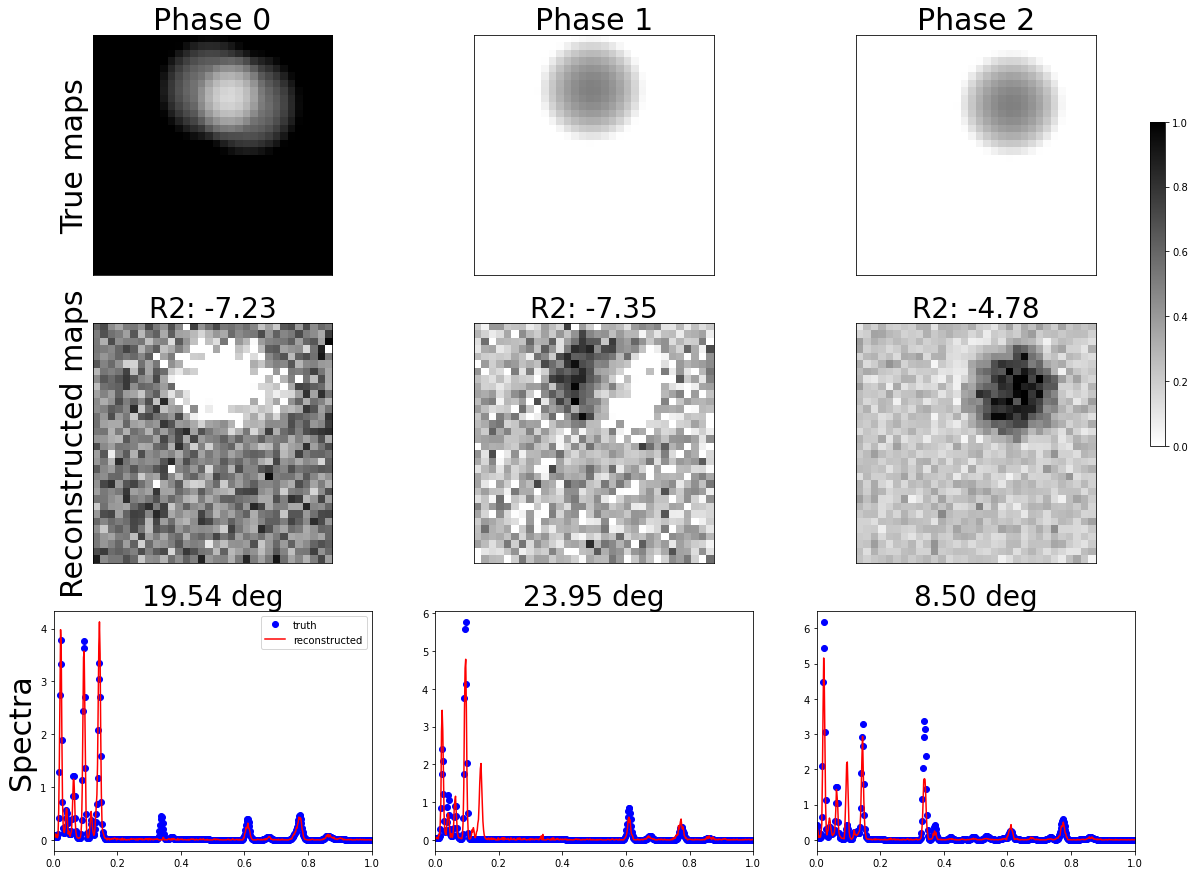

(3, 1024)
(3, 64, 64)
(500, 4096) (500, 3) (3, 4096)
3
It 10 / 1000: loss 0.127,  16.440 it/s
It 20 / 1000: loss 0.126,  17.139 it/s
It 30 / 1000: loss 0.126,  17.343 it/s
It 40 / 1000: loss 0.126,  17.474 it/s
It 50 / 1000: loss 0.126,  17.535 it/s
It 60 / 1000: loss 0.126,  17.532 it/s
It 70 / 1000: loss 0.126,  17.574 it/s
It 80 / 1000: loss 0.126,  17.568 it/s
It 90 / 1000: loss 0.126,  17.577 it/s
It 100 / 1000: loss 0.125,  17.614 it/s
It 110 / 1000: loss 0.125,  17.593 it/s
It 120 / 1000: loss 0.125,  17.422 it/s
It 130 / 1000: loss 0.125,  17.459 it/s
It 140 / 1000: loss 0.125,  17.462 it/s
It 150 / 1000: loss 0.125,  17.480 it/s
It 160 / 1000: loss 0.125,  17.512 it/s
It 170 / 1000: loss 0.125,  17.540 it/s
It 180 / 1000: loss 0.125,  17.538 it/s
It 190 / 1000: loss 0.125,  17.438 it/s
It 200 / 1000: loss 0.125,  17.458 it/s
It 210 / 1000: loss 0.125,  17.473 it/s
It 220 / 1000: loss 0.125,  17.487 it/s
It 230 / 1000: loss 0.125,  17.500 it/s
It 240 / 1000: loss 0.125,  17.505

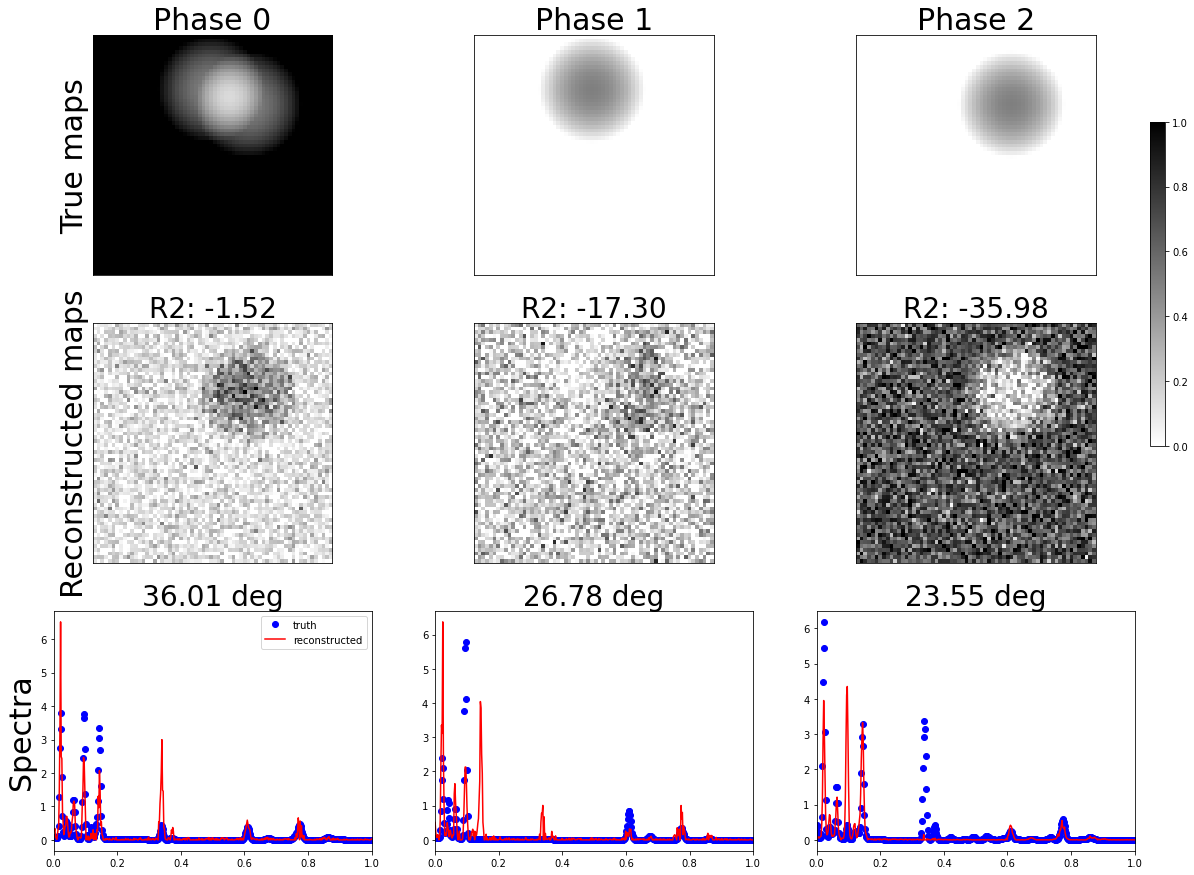

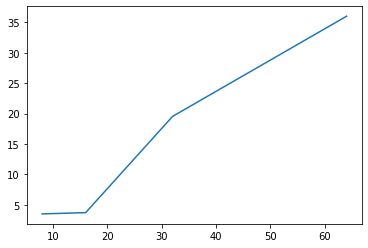

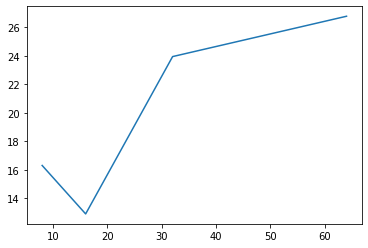

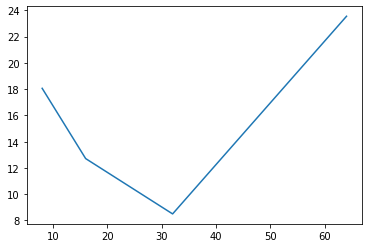

In [ ]:
G = spim.build_G("bremsstrahlung")
shape_2d = spim.shape_2d
# phases, weights = spim.phases, spim.weights
X = spim.X
est = SmoothNMF( n_components = 3,tol=0.000001, max_iter = 1000, G = None, lambda_L= 0., mu=0., force_simplex=False, init="nndsvdar")
Ximg = X.reshape((-1, pixels_side,pixels_side))
print(Ximg.shape)

downsampling_factors = [8,4,2,1]
results_0 = []
results_1 = []
results_2 = []

Hflat =None
W = None
for i in range(len(downsampling_factors)):
    downsample_factor_results_0 = []
    downsample_factor_results_1 = []
    downsample_factor_results_2 = []


    n = downsampling_factors[i]
    X_ = downsample(Ximg,n)
    Xflat = X_.reshape((X_.shape[0], -1))
    if (i > 0):
        print(Hflat.shape)
        H = Hflat.reshape((-1, pixels_side//n//2, pixels_side//n//2))
        H = H.repeat(2, axis = 1).repeat(2, axis = 2)
        Hflat = H.reshape((-1, pixels_side*pixels_side//n//n)) +0.1
        print(H.shape)
        print(Xflat.shape, W.shape, Hflat.shape)
        W =  W 
        
    D = est.fit_transform(Xflat)
    Hflat = est.H_
    W = est.W_

    Wdot = spim.phases
    Hflatdot = downsample_flat(spim.maps,n, pixels_side)

    angles, _ = find_min_angle(Wdot.T, W.T, unique=True, get_ind=True)

     
    results_0.append(angles[0])
    results_1.append(angles[1])
    results_2.append(angles[2])

   
 

    plot_results(Wdot, W, Hflatdot, Hflat, pixels_side//n)

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_0)
plt.show()

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_1)

plt.show()

plt.plot([pixels_side//downsampling_factors[i] for i in range(len(downsampling_factors))], results_2)
plt.show()